**Data Import and Technical Indicator Feature Engineering**


Import Libraries

In [1]:
import yfinance as yf
!pip install pandas_ta
import pandas_ta as ta
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from plotly.subplots import make_subplots
import plotly.graph_objects as go

**Load in Stock Ticker Price with yfinance Library**

In [2]:
# Load Ticker data
df = yf.download('NVDA', start="2022-10-25", end="2024-10-25")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

/tmp/ipython-input-1635624486.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('NVDA', start="2022-10-25", end="2024-10-25")
/usr/local/lib/python3.12/dist-packages/yfinance/scrapers/history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed


**Create 1-Trading Day Lag Structure**

In [3]:
# Shift data backward by one day to ensure no data leakage
df['Previous_Close'] = df['Close'].shift(1)  # Add previous day's close as a feature
df['Close_shifted'] = df['Close'].shift(1)
df['Open_shifted'] = df['Open'].shift(1)
df['High_shifted'] = df['High'].shift(1)
df['Low_shifted'] = df['Low'].shift(1)

df


Price,Open,High,Low,Close,Volume,Previous_Close,Close_shifted,Open_shifted,High_shifted,Low_shifted
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,
Date,,,,,,,,,,
2022-10-25,12.678063,13.283302,12.648100,13.244350,505482000,NaN,NaN,NaN,NaN,NaN
2022-10-26,12.852842,13.371189,12.692044,12.879807,532953000,13.244350,13.244350,12.678063,13.283302,12.648100
2022-10-27,13.612886,13.820625,13.105523,13.159455,583113000,12.879807,12.879807,12.852842,13.371189,12.692044
2022-10-28,13.087546,13.832610,13.044600,13.816629,521040000,13.159455,13.159455,13.612886,13.820625,13.105523
2022-10-31,13.760700,13.820625,13.280304,13.480053,486341000,13.816629,13.816629,13.087546,13.832610,13.044600
...,...,...,...,...,...,...,...,...,...,...
2024-10-18,138.622528,138.852445,137.233004,137.952759,176090200,136.883118,136.883118,139.292296,140.841769,136.823141
2024-10-21,138.082721,143.660812,137.952760,143.660812,264554500,137.952759,137.952759,138.622528,138.852445,137.233004


**Calculate Techinical Indicators based on the lagged/shifted columns**

In [5]:
# Calculate technical indicators on the shifted data

# Simple Moving Average (SMA): Average price over the last 50 periods
df['SMA_50'] = ta.sma(df['Close_shifted'], length=50)

# Exponential Moving Average (EMA): Weighted average that reacts faster to recent price changes, using 50 periods
df['EMA_50'] = ta.ema(df['Close_shifted'], length=50)

# Relative Strength Index (RSI): Momentum indicator that measures the magnitude of recent price changes to evaluate overbought/oversold conditions, using a 14-period lookback
df['RSI'] = ta.rsi(df['Close_shifted'], length=14)

# Moving Average Convergence Divergence (MACD): Trend-following momentum indicator, using 12 and 26 periods for the fast and slow EMAs and a 9-period signal line
macd = ta.macd(df['Close_shifted'], fast=12, slow=26, signal=9)
df['MACD'] = macd['MACD_12_26_9']        # MACD line
df['Signal_Line'] = macd['MACDs_12_26_9'] # Signal line

# Bollinger Bands: Volatility indicator using a 20-period moving average and 2 standard deviations
bollinger = ta.bbands(df['Close_shifted'], length=20, std=2)
df['BB_Upper'] = bollinger['BBU_20_2.0_2.0']  # Upper Bollinger Band
df['BB_Middle'] = bollinger['BBM_20_2.0_2.0'] # Middle Band (20-period SMA)
df['BB_Lower'] = bollinger['BBL_20_2.0_2.0']  # Lower Bollinger Band

# Stochastic Oscillator: Momentum indicator comparing closing prices to price ranges over 14 periods with a 3-period %D moving average
stoch = ta.stoch(df['High_shifted'], df['Low_shifted'], df['Close_shifted'], k=14, d=3)
df['%K'] = stoch['STOCHk_14_3_3'] # %K line (main line)
df['%D'] = stoch['STOCHd_14_3_3'] # %D line (3-period moving average of %K)

# Average True Range (ATR): Volatility indicator measuring the average range of price movement over the last 14 periods
df['ATR'] = ta.atr(df['High_shifted'], df['Low_shifted'], df['Close_shifted'], length=14)

In [6]:
df

Price,Open,High,Low,Close,Volume,Previous_Close,Close_shifted,Open_shifted,High_shifted,Low_shifted,...,EMA_50,RSI,MACD,Signal_Line,BB_Upper,BB_Middle,BB_Lower,%K,%D,ATR
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-25,12.678063,13.283302,12.648100,13.244350,505482000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-26,12.852842,13.371189,12.692044,12.879807,532953000,13.244350,13.244350,12.678063,13.283302,12.648100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-27,13.612886,13.820625,13.105523,13.159455,583113000,12.879807,12.879807,12.852842,13.371189,12.692044,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-28,13.087546,13.832610,13.044600,13.816629,521040000,13.159455,13.159455,13.612886,13.820625,13.105523,...,NaN,5.572110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,13.760700,13.820625,13.280304,13.480053,486341000,13.816629,13.816629,13.087546,13.832610,13.044600,...,NaN,17.242390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,138.622528,138.852445,137.233004,137.952759,176090200,136.883118,136.883118,139.292296,140.841769,136.823141,...,122.492985,64.340688,4.967808,3.961095,141.432273,126.573157,111.714041,78.684040,81.946467,5.159226
2024-10-21,138.082721,143.660812,137.952760,143.660812,264554500,137.952759,137.952759,138.622528,138.852445,137.233004,...,123.099251,65.339769,5.118710,4.192618,142.479944,127.672780,112.865617,85.845092,82.084787,4.931376


**Drop Trading Days With Missing Data (beginning of time series days)**

In [7]:
# Drop rows with missing values due to shifting and indicator calculation
df.dropna(inplace=True)

In [8]:
df

Price,Open,High,Low,Close,Volume,Previous_Close,Close_shifted,Open_shifted,High_shifted,Low_shifted,...,EMA_50,RSI,MACD,Signal_Line,BB_Upper,BB_Middle,BB_Lower,%K,%D,ATR
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-06,14.459524,14.994988,14.019964,14.844139,405044000,14.250734,14.250734,14.476508,14.549435,14.133851,...,15.400446,38.758800,-0.399837,-0.140028,18.465797,15.843239,13.220682,13.225586,13.496135,0.721102
2023-01-09,15.268714,16.039941,15.125856,15.612370,504231000,14.844139,14.844139,14.459524,14.994988,14.019964,...,15.378630,44.506870,-0.380738,-0.188170,18.436744,15.780252,13.123760,20.591771,16.102230,0.739240
2023-01-10,15.491491,15.946036,15.456526,15.893089,384101000,15.612370,15.612370,15.268714,16.039941,15.125856,...,15.387796,50.928338,-0.300152,-0.210566,18.280466,15.703279,13.126093,35.184103,23.000487,0.771851
2023-01-11,15.824159,16.011971,15.547436,15.984998,353285000,15.893089,15.893089,15.491491,15.946036,15.456526,...,15.407612,53.065576,-0.211201,-0.210693,18.157047,15.648734,13.140421,56.096071,37.290649,0.751684
2023-01-12,16.083901,16.620363,15.476509,16.494490,551409000,15.984998,15.984998,15.824159,16.011971,15.547436,...,15.430254,53.775418,-0.131771,-0.194909,17.929128,15.572111,13.215094,71.527638,54.269271,0.731173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-18,138.622528,138.852445,137.233004,137.952759,176090200,136.883118,136.883118,139.292296,140.841769,136.823141,...,122.492985,64.340688,4.967808,3.961095,141.432273,126.573157,111.714041,78.684040,81.946467,5.159226
2024-10-21,138.082721,143.660812,137.952760,143.660812,264554500,137.952759,137.952759,138.622528,138.852445,137.233004,...,123.099251,65.339769,5.118710,4.192618,142.479944,127.672780,112.865617,85.845092,82.084787,4.931376


**Modeling: Backtest**


Choose # of days for rolling training data window and Choose Technical Indicators

In [9]:
# Parameters
window_size = 20  # 4 weeks of trading days (5 days per week * 4)

# List of indicators to test, including Previous_Close
indicators = ['SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Middle', 'BB_Lower', '%K', '%D', 'ATR', 'Close_shifted', 'Previous_Close']

# Initialize a dictionary to store predictions, actuals, daily MAE for each indicator
results = {indicator: {'predictions': [], 'actual': [], 'daily_mae': []} for indicator in indicators}


Loop over multiple 20-Day Train Datasets for Model Building and Next Day Test Datasets for Model Evaluation

In [10]:
# Sequentially predict the actual close price using a rolling 4 weeks window, set by window_size
for i in range(window_size, len(df) - 1):
    train_df = df.iloc[i - window_size:i]  # Training window
    test_index = i + 1  # Index of next day's prediction
    actual_close_price = df['Close'].iloc[test_index]  # Next day's actual closing price

    # Individual indicators as predictors (plus Previous_Close)
    for indicator in indicators[:-1]:  # Exclude Previous_Close from standalone tests
        X_train = train_df[[indicator, 'Previous_Close']]
        y_train = train_df['Close']
        X_train = sm.add_constant(X_train)  # Add constant for intercept

        model = sm.OLS(y_train, X_train).fit()
        X_test = pd.DataFrame({indicator: [df[indicator].iloc[test_index]], 'Previous_Close': [df['Previous_Close'].iloc[test_index]]})
        X_test = sm.add_constant(X_test, has_constant='add')  # Add constant for prediction

        prediction = model.predict(X_test)[0]
        results[indicator]['predictions'].append(prediction)
        results[indicator]['actual'].append(actual_close_price)

        daily_mae = mean_absolute_error([actual_close_price], [prediction])
        results[indicator]['daily_mae'].append(daily_mae)

**Prediction Evaluation**

Preparing Features

In [11]:
# Select features (same indicators you used)
features = [
    'SMA_50', 'EMA_50', 'RSI', 'MACD', 'Signal_Line',
    'BB_Upper', 'BB_Middle', 'BB_Lower',
    '%K', '%D', 'ATR',
    'Close_shifted', 'Previous_Close'
]

target = 'Close'

X = df[features]
y = df[target]


Train test split

In [12]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


DNN model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),

    Dense(1)  # Output layer for price prediction
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

Training the DNN

In [15]:
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2354.1614 - mae: 44.1165 - val_loss: 9611.7598 - val_mae: 97.0919
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2294.1448 - mae: 43.0797 - val_loss: 6686.5000 - val_mae: 81.3058
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1212.1580 - mae: 29.2653 - val_loss: 1225.2087 - val_mae: 33.2338
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 465.1949 - mae: 18.4545 - val_loss: 821.0927 - val_mae: 20.7005
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 338.3481 - mae: 14.8658 - val_loss: 486.7019 - val_mae: 17.4604
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 261.8125 - mae: 13.0656 - val_loss: 416.3086 - val_mae: 13.9589
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 243.6508 - mae: 12.5904 - val_loss: 219.5829 - val_mae: 10.1023
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 197.7726 - mae: 11.1814 - val_loss: 340.8111 - val_mae: 15.0616
Epoch 9/50

Model Evaluation

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
MAE: 7.546241283416748
RMSE: 8.55883844427132


Plot Actual vs Actual Predicte Prices

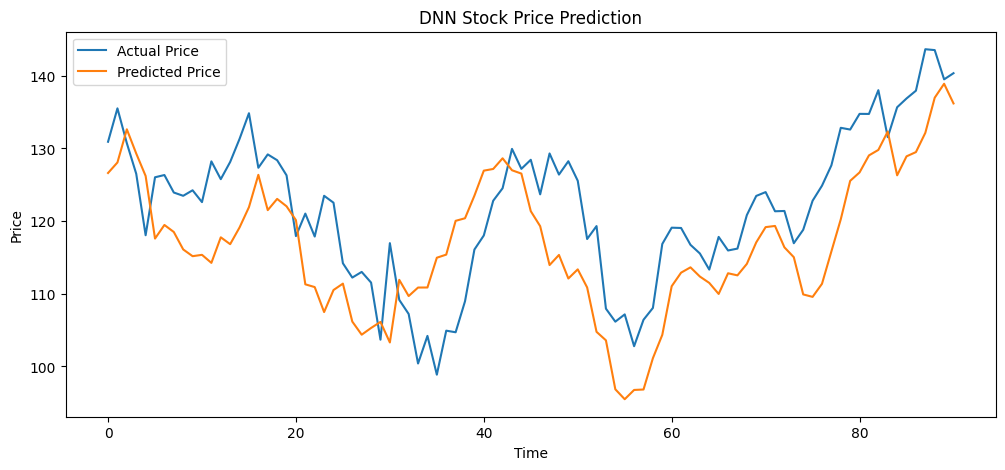

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.legend()
plt.title("DNN Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


Predicting next trading day

In [18]:
latest_data = X.iloc[-1:]
latest_scaled = scaler.transform(latest_data)

next_day_price = model.predict(latest_scaled)[0][0]
print("Predicted Next Day Close Price:", next_day_price)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Next Day Close Price: 136.19934


Preparing data for backtesting

In [19]:
# Align predictions with test dataframe
test_df = df.iloc[len(df) - len(y_test):].copy()
test_df['Predicted_Close'] = y_pred


Defining trading parameters

In [20]:
initial_capital = 100000  # ₹1,00,000
capital = initial_capital

position = 0      # 0 = no position, 1 = holding stock
buy_price = 0
shares = 0

stop_loss_pct = 0.02      # 2% stop loss
take_profit_pct = 0.04   # 4% take profit

portfolio_values = []


Trading + Risk parameters

In [22]:
for i in range(len(test_df) - 1):

    today_price = test_df['Close'].iloc[i].item() # Use .item() to get the scalar value
    predicted_price = test_df['Predicted_Close'].iloc[i]

    # BUY condition
    if position == 0 and predicted_price > today_price:
        shares = capital // today_price
        buy_price = today_price
        capital -= shares * buy_price
        position = 1

    # SELL condition
    elif position == 1:
        stop_loss_price = buy_price * (1 - stop_loss_pct)
        take_profit_price = buy_price * (1 + take_profit_pct)

        if (
            today_price <= stop_loss_price or
            today_price >= take_profit_price or
            predicted_price < today_price
        ):
            capital += shares * today_price
            shares = 0
            position = 0

    # Portfolio value
    portfolio_value = capital + (shares * today_price)
    portfolio_values.append(portfolio_value)

Buy-and-Hold Benchmark

In [24]:
buy_and_hold_shares = initial_capital // test_df['Close'].iloc[0].item()
buy_and_hold_values = buy_and_hold_shares * test_df['Close'].values[:len(portfolio_values)]

Performance Comparison Plot

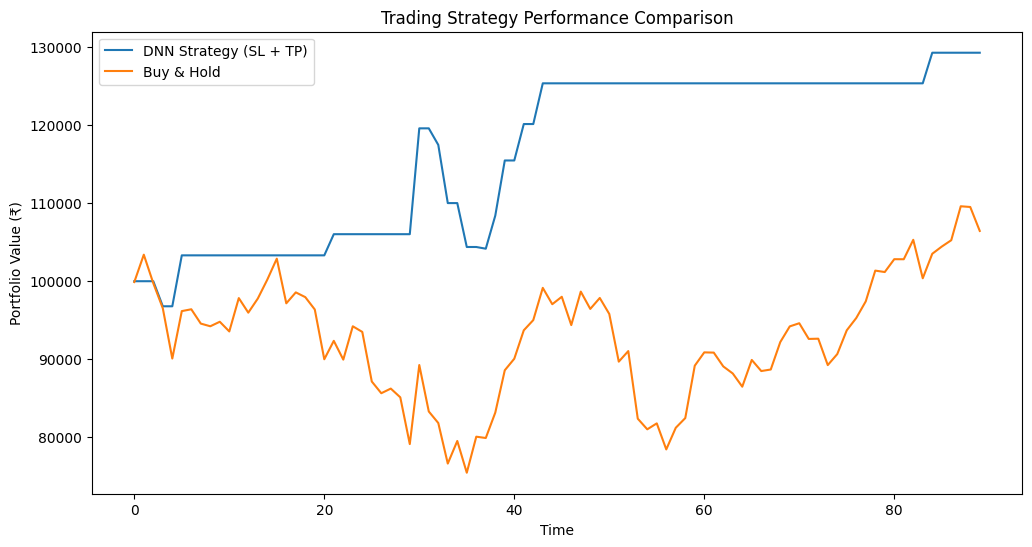

In [25]:
plt.figure(figsize=(12,6))
plt.plot(portfolio_values, label='DNN Strategy (SL + TP)')
plt.plot(buy_and_hold_values, label='Buy & Hold')
plt.xlabel('Time')
plt.ylabel('Portfolio Value (₹)')
plt.title('Trading Strategy Performance Comparison')
plt.legend()
plt.show()


Final Returns Summary

In [27]:
strategy_return = (portfolio_values[-1] - initial_capital) / initial_capital * 100
buy_hold_return = (buy_and_hold_values[-1] - initial_capital) / initial_capital * 100

print(f"DNN Strategy Return: {strategy_return:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return.item():.2f}%")

DNN Strategy Return: 29.31%
Buy & Hold Return: 6.45%
